In [1]:
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm

### Тесты
1) **ANOVA** – тест, предназначенный для сравнения средних значений между группами. Может сравнивать различие по одной категорной переменной, по паре, по их взаимодействию, а также с учётом зависимых измерений. Требует нормальности остатков, гомогенности дисперсий, а также достаточно большого количества.
2) **Тест Тьюки** определяет, состоит ли ваша выборка из групп, которые отличаются друг от друга. Каждое среднее сравнивается со средним всех других групп с помощью "Честной значимой разницы", которая показывает, насколько далеко друг от друга находятся группы. Нередко используется для анализа результатов, полученных с помощью ANOVA (можно проверять предположения, сделанные на основе визуального анализа – что среднее одной группы превосходит среднее по всем остальным).


# Задача 1. Сравнение эффективности программ подготовки к экзаменам.
Предположим, что мы хотим узнать, одинаковы ли по эффективности три разных программ подготовки к экзаменам. Ниже приведена таблица с оценками студентов, обучавшихся по соответственным программам.

![(Таблица)](hw3_task1_table.png)

Проведите анализ того, различаются ли программы по эффективности и
предположите, какая из них наилучшая/наихудшая. Оба пункта следует
подкрепить соответствующими методами.

## Решение

Для данной задачи подходит тест Тьюки так как он позволяет определить насколько группы различны.

In [2]:
data = pd.read_csv("students.csv")
data

,group 1,group 2,group 3
0,85,91,79
1,86,92,78
2,88,93,88
3,75,85,94
4,78,87,92
5,94,84,85
6,98,82,83
7,79,88,85
8,71,95,82
9,80,96,81


In [3]:
res = st.tukey_hsd(*data.to_numpy().T)
groups = ['Group 1', 'Group 2', 'Group 3']
pd.DataFrame(res.pvalue, columns=groups, index=groups)

,Group 1,Group 2,Group 3
Group 1,1.000000,0.115991,0.892477
Group 2,0.115991,1.000000,0.258352
Group 3,0.892477,0.258352,1.000000


$H_0$ - группы не различны. В данном случае мы не можем отвергнуть эту гипотезу ни для одной пары групп. Следовательно, группы примерно одинаковы в плане эффективности.

Посмотрим на значение статистики:

In [4]:
pd.DataFrame(res.statistic, columns=groups, index=groups)

,Group 1,Group 2,Group 3
Group 1,0.0,-5.9,-1.3
Group 2,5.9,0.0,4.6
Group 3,1.3,-4.6,0.0


Группа 2 имеет наивысшее среднее из всех значений статистики, но невозможно однозначно называть её лучшей - поскольку ранее заключили, что эффективностью она не отличается от остальных групп.

Посмотрим на график:

<Axes: >

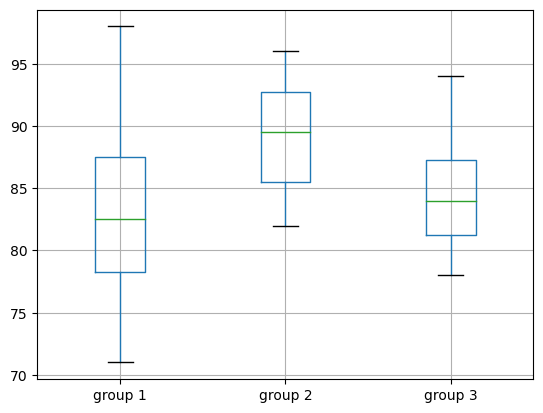

In [5]:
data.boxplot()

# Задача 3. Оценка эффективности программы тренировок.

Предположим, что мы хотим узнать, оказывает ли эффект программа
тренировок на пульс в покое у тех, кто её проходит. Мы отслеживали данный
параметр у 5 людей в течение 8 месяцев и результаты получились
следующие:

![(Table)](hw3_task3_table.png)

Проведите анализ того, оказывает ли программа эффект на ЧСС в покое.
Анализ должен быть подкреплён одним соответствующим тестом.
